In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [2]:
%load_ext autoreload
%autoreload 2

import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

import numpy as np
import scipy

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, LogisticRegressionLoss
from methods import *

In [3]:
def train_loop(w_0: float, dataset_name: str, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # dataset
    if dataset_name == "synthetic":
        train_data, train_target = utils.make_synthetic_binary_classification(1000, 100)
    else:
        train_data, train_target = utils.get_LIBSVM(dataset_name)
        from sklearn.preprocessing import normalize
        train_data = normalize(train_data, norm="l2", axis=1)
        
    
    # parameters
    w = np.full((train_data.shape[1]), fill_value=w_0)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(train_data, train_target, lmd=1e-3)
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)        
        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        optim.step(oracle=loss_function)
        
        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
        history["lr"].append(optim.lr)
    
    return history

In [49]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, ylims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if f_star is None:
        f_star = np.min([x["loss"] for x in histories])
    else:
        f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        
        for i, loss in enumerate(f_suboptim):
            if loss <= threshold:
                history["lr"][i] = 0.0
        
        markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["loss"]), len(history["loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].semilogy(history["lr"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    if f_star.sum() == 0.0:
        ax[0].set_ylabel(r"$f(x_k)/f(x_0)$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")

    ax[1].set_ylabel("step-size")
                
    ax[0].set_xlabel("Steps")
    ax[1].set_xlabel("Steps")
    
    if xlims is not None:
        ax[0].set_xlim(right=xlims[1])
        ax[1].set_xlim(right=xlims[1])
        
    if ylims is not None:
        ax[0].set_ylim(bottom=ylims[0], top=ylims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

In [39]:
np.random.seed(0)

dataset_name = "a1a"

n_steps = 30

histories = []
labels = []

w_0 = 10.0

# Damped Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.25)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton, lr=0.25")


# Armijo Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
lr_arm = hist["lr"]
histories.append(hist)
labels.append(r"Armijo Newton")


# Greedy Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
lr_gn = hist["lr"]
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=Line41, verbose=False)
lr_41 = hist["lr"]
histories.append(hist)
labels.append("GRLS")

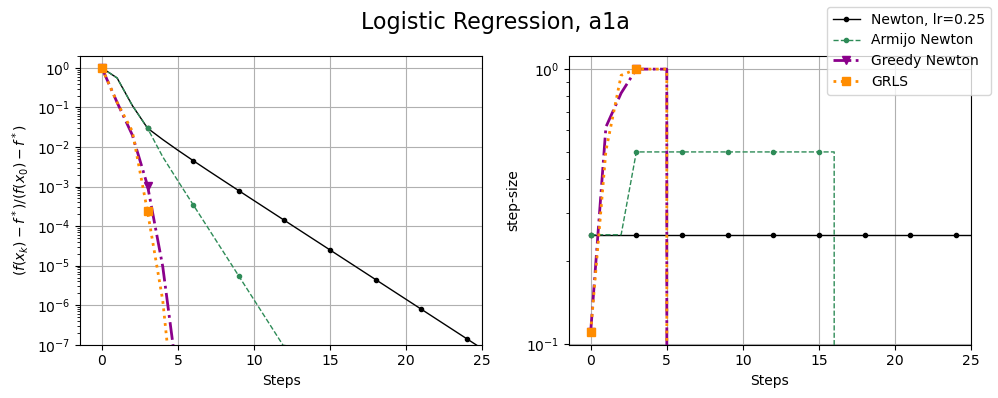

In [50]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "darkorange", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "s", "p"],
        f_star=f_star, 
        ylims=(1e-7, 2.0),
        xlims=(0.0, 25),
        suptitle=f"Logistic Regression, {dataset_name}",
        filename=f"plots/logreg_linesearch_{dataset_name}.pdf")

In [67]:
np.random.seed(0)

dataset_name = "mushrooms"

n_steps = 20

histories = []
labels = []

w_0 = 10.0

# Damped Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.9)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton, lr=0.9")

# Armijo Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
lr_arm = hist["lr"]
histories.append(hist)
labels.append(r"Armijo Newton")

# Greedy Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
lr_gn = hist["lr"]
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=Line41, verbose=False)
lr_41 = hist["lr"]
histories.append(hist)
labels.append("GRLS")

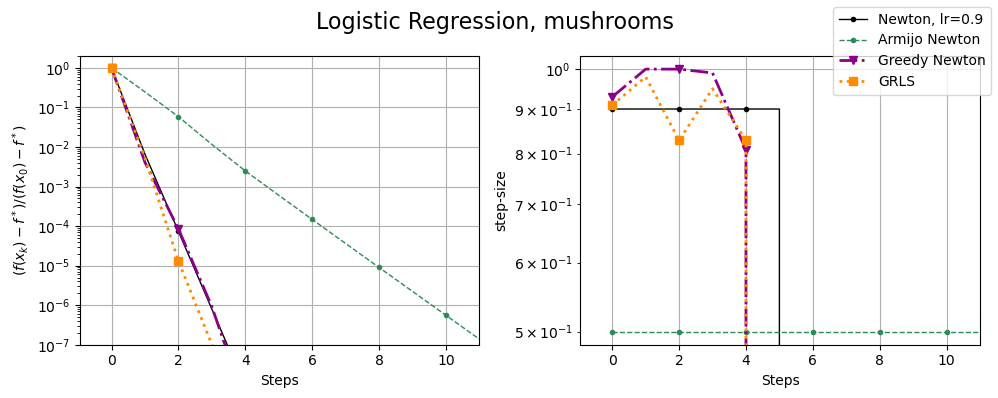

In [68]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "darkorange", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "s", "p"],
        f_star=f_star, 
        ylims=(1e-7, 2.0),
        xlims=(0.0, 11),
        suptitle=f"Logistic Regression, {dataset_name}",
        filename=f"plots/logreg_linesearch_{dataset_name}.pdf")

In [69]:
np.random.seed(0)

dataset_name = "w7a"

n_steps = 15

histories = []
labels = []

w_0 = 10.0

# Damped Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.5)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton, lr=0.5")


# Armijo Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
lr_arm = hist["lr"]
histories.append(hist)
labels.append(r"Armijo Newton")


# Greedy Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
lr_gn = hist["lr"]
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=Line41, verbose=False)
lr_41 = hist["lr"]
histories.append(hist)
labels.append("GRLS")

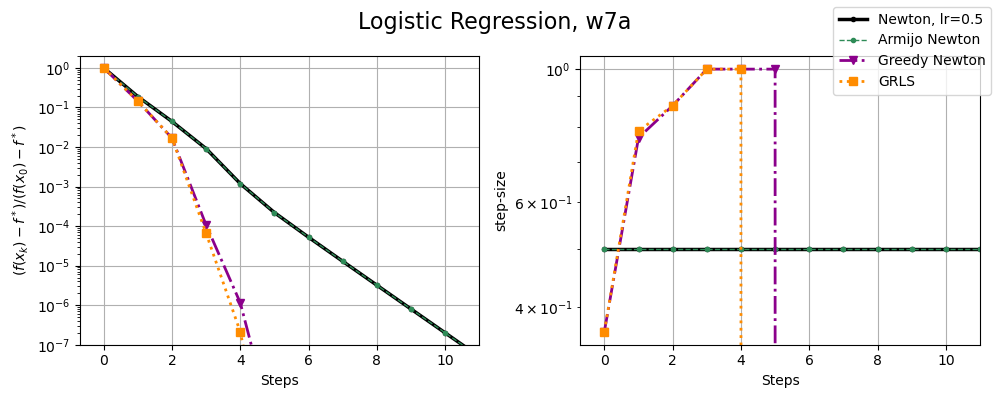

In [70]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "darkorange", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[2.5, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "s", "p"],
        f_star=f_star, 
        ylims=(1e-7, 2.0),
        xlims=(0.0, 11),
        suptitle=f"Logistic Regression, {dataset_name}",
        filename=f"plots/logreg_linesearch_{dataset_name}.pdf")

In [71]:
np.random.seed(0)

dataset_name = "colon-cancer"

n_steps = 15

histories = []
labels = []

w_0 = 10.0

# Damped Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps+n_steps, optimizer=DampedNewton, lr=0.65)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton, lr=0.65")


# Armijo Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=0.5, tau=0.1)
lr_arm = hist["lr"]
histories.append(hist)
labels.append(r"Armijo Newton")


# Greedy Newton
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GreedyNewton, verbose=False)
lr_gn = hist["lr"]
histories.append(hist)
labels.append(r"Greedy Newton")

# Line41
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=Line41, verbose=False)
lr_41 = hist["lr"]
histories.append(hist)
labels.append("GRLS")

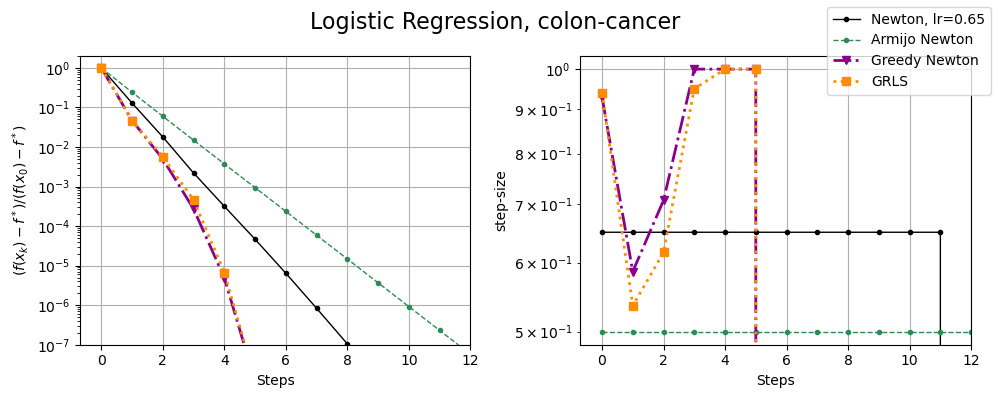

In [72]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "seagreen", "darkmagenta", "darkorange", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "s", "p"],
        f_star=f_star, 
        ylims=(1e-7, 2.0),
        xlims=(0.0, 12),
        suptitle=f"Logistic Regression, {dataset_name}",
        filename=f"plots/logreg_linesearch_{dataset_name}.pdf")